## Process
### Start Bullet Server with ControlHubPlugin
#### windows
```cmd
rnb-control\BulletSimControl\x64\Release\BulletSimControl.exe
```
#### linux
```bash
rnb-control/BulletSimControl/bin/BulletSimControl
```

In [1]:
from bullet_sim_client import *
from utils.trajectory_client.trajectory_client import TrajectoryClient
from utils.web_client import WebClient

## Connect and set physics

In [2]:
init_bullet_sim()

### Load model

In [3]:
ROBOT_TYPE = RobotType.KUKA_IIWA
pc = BulletControlHubClient(get_urdf_path(ROBOT_TYPE), xyz=(0,0,0))

## implement control in python

### initialize state

In [4]:
if ROBOT_TYPE==RobotType.INDY7:
    Q0 = [0, 0, -np.pi / 2, 0, -np.pi / 2, 0] # for indy
else:
    Q0 = [0, -np.pi / 8, 0, np.pi / 4,  0, -np.pi / 8, 0] # for iiwa

pc.initialize_state(Q=Q0)
q, qdot, qddot,q_n, qdot_n, p, p_n, M, C, M_n, C_n, \
        tauGrav, tauExt, J, Jdot, J_n, Jdot_n, FText, _, _ = pc.update_state()

### test loop

In [5]:
from utils.algebra import *

In [6]:
## Calculate s-curve trajectory in task space
se3_alg = Combined([Euclidean(3), RotationUVW()])

DUR= 3
N_div = int(DUR/pc.DT)
P0 = np.array(p)
P1 = P0 + [0.3,0.3,-0.3, 0, -np.pi/2, 0]
P2 = P0
traj = []

dp0, dp1, dp2 = se3_alg.diff_in_alg(P0, [P0, P1, P2])
a, b, v0, q0 = calc_cubic_coeffs(DUR, np.zeros_like(dp0), dp0, dp1, dp2)
dp_list = calc_cubic_traj(np.arange(0, DUR+pc.DT, pc.DT), a, b, v0, q0)
traj+=list(se3_alg.add_from_alg(P0, dp_list))


dp0, dp1, dp2 = se3_alg.diff_in_alg(P1, [P1, P2, P2])
v0 = calc_cubic_vel(DUR, a, b, v0)
a, b, v0, q0 = calc_cubic_coeffs(DUR, v0, dp0, dp1, dp2)
dp_list = calc_cubic_traj(np.arange(0, DUR+pc.DT, pc.DT), a, b, v0, q0)
traj+=list(se3_alg.add_from_alg(P1, dp_list))

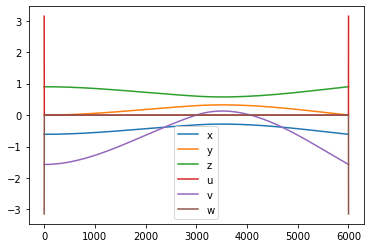

In [7]:
plt.plot(traj)
plt.legend("xyzuvw")

## Show points

In [8]:
p0_axes = show_axis(*T2xyzquat(SE3(Rot_zyx(*list(reversed(P0[3:]))), P0[:3])))
p2_axes = show_axis(*T2xyzquat(SE3(Rot_zyx(*list(reversed(P1[3:]))), P1[:3]))) # !! Simulation right after adding obj diverges!!!

In [9]:
## Reset variables
k_p = np.array([1000]*3+[1000]*3, dtype=float)
k_v = np.array([1]*3+[1]*3, dtype=float)
tau_max = 300
f_c = 200

eI_nr = np.zeros(6)
lpf_q = LowPassFilter(pc.DT, f_c, Q0)
lpf_qdot = LowPassFilter(pc.DT, f_c, np.zeros(pc.joint_num))
lpf_qddot = LowPassFilter(pc.DT, f_c, np.zeros(pc.joint_num))

In [10]:
dyn_values = []
traj_lp = []
timer = StrictTimer(pc.DT)
for p_d in list(traj)+[traj[-1]]*int(1/pc.DT):
    timer.sleep()
    q, qdot, qddot,q_n, qdot_n, p, p_n, M, C, M_n, C_n, \
        tauGrav, tauExt, J, Jdot, J_n, Jdot_n, FText, _, _ = pc.update_state()
    traj_lp.append(lpf_q.update(q))
    qdot = lpf_qdot.update(qdot)
    qddot = lpf_qddot.update(qddot)
    
    pdot = np.matmul(J, qdot)
    pdot_n = np.matmul(J, qdot_n)
    
    # PD control (outer-loop)
    e_dr = se3_alg.diff_in_alg(p_d, [p])[0]
    edot_dr = - se3_alg.diff_in_alg(p, [p + pdot*pc.DT])[0]/pc.DT
    tauPD = np.matmul(J_n.T, -k_p*e_dr - k_v*edot_dr)
    torque_out, qddot_n = tauGrav+tauPD, qddot # Gravity compenstation

    pc.apply_torque(torque_out, qddot_n)
    pb.stepSimulation()
    dyn_values.append(deepcopy([q, qdot, qddot,q_n, qdot_n, p, p_n, M, C, M_n, C_n, \
        tauGrav, tauExt, J, Jdot, J_n, Jdot_n, FText, torque_out, qddot_n]))

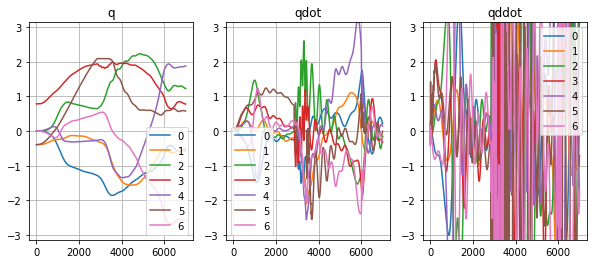

In [11]:
plt.figure(figsize=(10,4))
for i_p in range(3):
    plt.subplot(1,3,i_p+1)
    plot_values(pc, dyn_values, i_p)
    plt.ylim(-np.pi, np.pi)
    plt.grid()

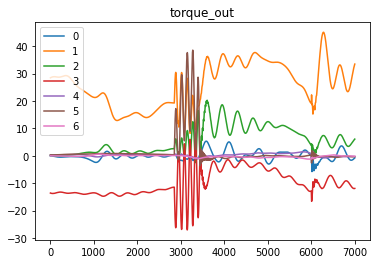

In [12]:
plot_values(pc, dyn_values, -2)

## Test Controller in ControlHub

In [13]:
q, qdot, qddot,q_n, qdot_n, p, p_n, M, C, M_n, C_n, \
    tauGrav, tauExt, J, Jdot, J_n, Jdot_n, FText, _, _ = pc.update_state()

### initialize control hub

In [14]:
pc.set_control_hub(ControlMode.TASK_CONTROL) ## Init ControlHub

### Initialize state

In [15]:
if ROBOT_TYPE==RobotType.INDY7:
    Q0 = [0, 0, -np.pi / 2, 0, -np.pi / 2, 0] # for indy
#     Q0 = np.deg2rad([0,-7,-90,-37,-75,0]) # for indy
else:
    Q0 = [0, -np.pi / 8, 0, np.pi / 4,  0, -np.pi / 8, 0] # for iiwa

pc.initialize_state(Q=Q0)

## Set controller to PD on WebUI
* http://localhost:9991/
* set all Kp = 100, f_cut=200

## Test TrajectoryClient

In [16]:
traj_client = TrajectoryClient("localhost", server_port=9981)

In [17]:
P0 = traj_client.get_qcur()
P2 = np.add(P0, [0.1,0.2,-0.2,0,np.pi/4, -np.pi/4])
p0_axes = show_axis(*T2xyzquat(SE3(Rot_zyx(*list(reversed(P0[3:]))), P0[:3])))
p2_axes = show_axis(*T2xyzquat(SE3(Rot_zyx(*list(reversed(P2[3:]))), P2[:3]))) # !! Simulation right after adding obj diverges!!!
pb.stepSimulation()
pc.initialize_state(Q=Q0)

In [18]:
start_simulation_thread() # ON

In [19]:
traj_client.start_tracking()

{'follow': True}

In [20]:
traj_client.move_joint_s_curve(P0, N_div=20, 
                               start_tracking=False, auto_stop=False, 
                               wait_finish=False)
traj_client.move_joint_s_curve(P2, q0=P0, N_div=100, 
                               start_tracking=False, auto_stop=False, 
                               wait_finish=False)
traj_client.move_joint_s_curve(P0, q0=P2, N_div=100, 
                               start_tracking=False, auto_stop=False, 
                               wait_finish=False)

In [21]:
traj_client.stop_tracking()

{'stop': True}

In [22]:
stop_simulation_thread() # OFF

## Unload Robot

In [23]:
pc.unload()